## Cindey Caine A10834042
## CSE 151 PA2

## 1. First 3 levels of tree

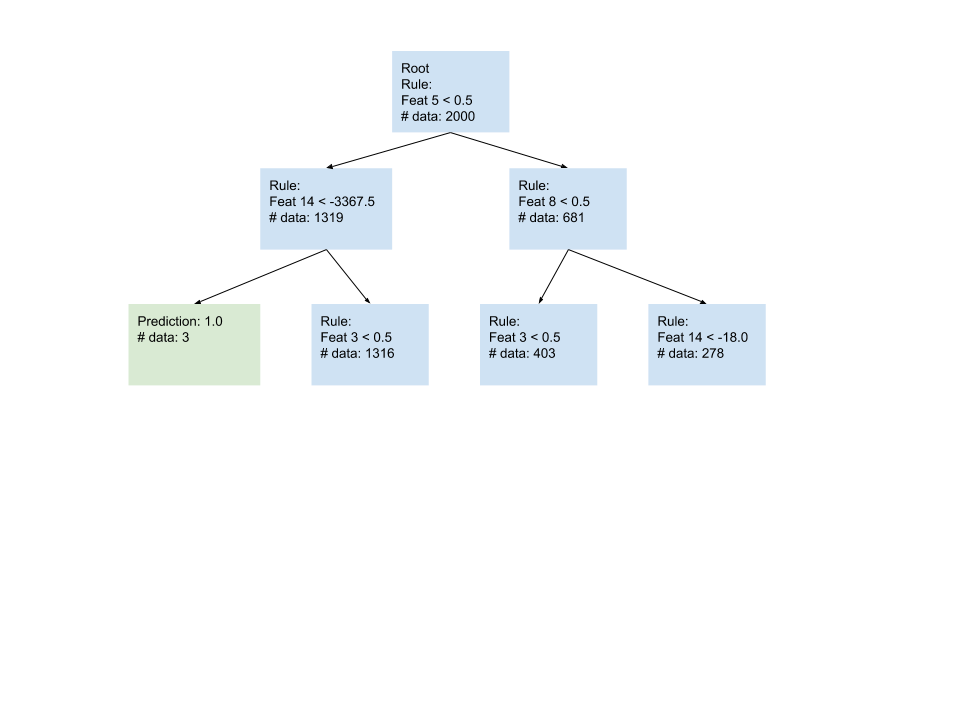

In [39]:
Image("diagram.png")

## 2. Training and Test Error

In [40]:
print("Training Error: " + str(trainErr))

Training Error: 0.0


In [41]:
print("Test Error: " + str(testErr))

Test Error: 0.186


## 3. Validation and Test Error post Pruning 

In [42]:
print("Validation Error(1 Prune): " + str(postPrune[0][0]))
print("Test Error(1 Prune): " + str(postPrune[0][1]))

Validation Error(1 Prune): 0.121
Test Error(1 Prune): 0.127


In [43]:
print("Validation Error(2 Prune): " + str(postPrune[1][0]))
print("Test Error(2 Prune): " + str(postPrune[1][1]))

Validation Error(2 Prune): 0.12
Test Error(2 Prune): 0.127


## 4. The most prominent feature would be feature 5 or "PAYMENT_DELAY_SEPTEMBER" for predicting credit card fraud. This is because feature 5 had the lowest conditional entropy. Therefore, the tree decided to split based on this feature since it would make the "purest" impure node splits. 

In [25]:
import numpy as np
import pandas as pd
import math
from copy import deepcopy
from random import randint
from queue import *
from collections import Counter
from IPython.display import Image

In [2]:
# Read in data
with open('../pa2train.txt') as f:
    train = f.readlines()
train = [x.strip() for x in train] 

with open('../pa2validation.txt') as f:
    val = f.readlines()
val = [x.strip() for x in val] 

with open('../pa2test.txt') as f:
    test = f.readlines()
test = [x.strip() for x in test] 

In [3]:
# create empty lists for data sorting
trainData = []
trainLabel = []

valData = []
valLabel = []

testData = []
testLabel = []

In [4]:
# Remove spaces and split into label/data
for i in range (0,len(train)):
    train[i] = train[i].split(" ")
    trainLabel.append(train[i][22])
    trainData.append(train[i][:22])

for i in range (0,len(val)):
    val[i] = val[i].split(" ")
    valLabel.append(val[i][22])
    valData.append(val[i][:22])

for i in range (0,len(test)):
    test[i] = test[i].split(" ")
    testLabel.append(test[i][22])
    testData.append(test[i][:22])

In [5]:
# convert label string to int
trainLabel = [float(i) for i in trainLabel]

valLabel = [float(i) for i in valLabel]

testLabel = [float(i) for i in testLabel]

In [6]:
# convert data string to int
for i in range(0,len(trainData)):
    trainData[i] = [float(j) for j in trainData[i]]
    
for i in range(0,len(valData)):
    valData[i] = [float(j) for j in valData[i]]
    
for i in range(0,len(testData)):
    testData[i] = [float(j) for j in testData[i]]

In [7]:
class Node:
    def __init__(self):
        self.left_child = None
        self.right_child = None
        self.rule = None
        self.labels = None
        self.labelsCount = None
        self.parent = None
        self.side = None
class Tree:
    def __init__(self):
        self.root = None

In [8]:
def calcLog(prob):
    if(prob == 0):
        return 0.0
    else:
        return (prob)*math.log(prob)

In [9]:
def splitData(data, labels):
    featEn = []

    # for i from 0 to number of features(# of columns)
    for i in range (0,len(data[0])):
        column = []
        threshold = []
    
        # for j from 0 to number of data points(# of rows)
        for j in range (0, len(data)):
            # getting each i feature value in the j column
            column.append(data[j][i])
        
        # get n unique values in the feature
        uFeat = list(set(column))

        uFeat.sort()
        
        if(len(uFeat) != 1):     
            # get thresholds between each unique value for n-1 threshold values
            for k in range (0, len(uFeat)-1):
                threshold.append((uFeat[k]+uFeat[k+1])/2)
            
            condEn = []
    
            # for m from 0 to number of thresholds(n-1)
            for m in range (0, len(threshold)):
                numLess = 0
                lessYes = 0
                lessNo = 0
                greatYes = 0
                greatNo = 0
        
                # count number of features less than the threshold (P(feature) = [probLess,probGreat])
                for n in range (0, len(column)):
                    if(column[n] < threshold[m]):
                        if(labels[n] == 1):
                            lessYes += 1
                        else:
                            lessNo += 1
                        numLess += 1
                    else:
                        if(labels[n] == 1):
                            greatYes += 1
                        else:
                            greatNo += 1
                
                # (P(feature) = [probLess,probGreat])               
                probLess = numLess/len(column)
                probGreat = (len(column)-numLess)/len(column)
    
                # P(label|feature < threshold)
                less = (lessYes/numLess,lessNo/numLess)
                # P(label|feature >= threshold)
                great = (greatYes/(len(column)-numLess),greatNo/(len(column)-numLess))
    
                # calculate cond entropy
                en = probLess*(-(calcLog(less[0]) + calcLog(less[1]))) + probGreat*(-(calcLog(great[0]) + calcLog(great[1])))
    
                # append threshold value and its entropy to list
                condEn.append((threshold[m], en))
        
       
            # sort entropy for that feature
            condEn.sort(key=lambda tup: tup[1]) 

            # put the lowest entropy of each feat in a list
            featEn.append((condEn[0][0],condEn[0][1],i))
            
    featEn.sort()
    
    return featEn[0]

In [10]:
def setSplit(data,rule,labels):
    # left and right data + label
    left = []
    leftLabel = []
    right = []
    rightLabel = []

    # for each i data point
    for i in range (0,len(data)):
        # check if the data point in the feature is < lowest entropy threshold chosen
        if(data[i][rule[2]] < rule[0]):
            left.append(data[i])
            leftLabel.append(labels[i])
        else:
            right.append(data[i])
            rightLabel.append(labels[i])
    # return left data + label and right data + label
    return left, right, leftLabel, rightLabel       

In [11]:
# create new tree
id3Tree = Tree()
# create root node for the tree
rootNode = Node()
# give it the training data
rootNode.rule = trainData
rootNode.labels = trainLabel

# assign root to tree
id3Tree.root = rootNode

# create queue for iteration and add root node
nodeQueue = Queue()
nodeQueue.put(rootNode)

In [12]:
while(nodeQueue.qsize() != 0):
    # get out the top node in queue
    curNode = nodeQueue.get()
    
    # if node is not pure:
    if(len(set(curNode.labels)) != 1):
        # decide where to split
        bestSplit = splitData(curNode.rule,curNode.labels)
    
        # split data via the new rule
        (left,right,leftLabel,rightLabel) = setSplit(curNode.rule,bestSplit,curNode.labels)
       
        # create node children
        leftNode = Node()
        rightNode = Node()
    
        # sign data/labels to children
        leftNode.rule = left
        leftNode.labels = leftLabel
        rightNode.rule = right
        rightNode.labels = rightLabel
    
        leftNode.parent = curNode
        rightNode.parent = curNode
        
        leftNode.side = 1
        rightNode.side = 0
        
        # change rule to splitting rule instead of data
        curNode.rule = bestSplit
        # count labels of how many data points were split in the node
        curNode.labelsCount = len(curNode.labels)
        
        # assign children to current node
        curNode.left_child = leftNode
        curNode.right_child = rightNode  
    
        # put new nodes in queue if len > 1
        if(len(leftNode.rule) > 1):
            nodeQueue.put(leftNode)
        if(len(rightNode.rule) > 1):
            nodeQueue.put(rightNode)

In [13]:
set(id3Tree.root.left_child.left_child.labels)

{1.0}

In [14]:
rootNode.labelsCount

2000

In [15]:
def calcError(data, labels, tree):
    # init prediction
    pred = []

    # predict training data
    for i in range (0,len(data)):
        curNode = tree.root
    
        while(curNode.right_child != None and curNode.left_child != None):
            if(data[i][curNode.rule[2]] < curNode.rule[0]):
                curNode = curNode.left_child
            else:
                curNode = curNode.right_child
            
        nodeLabels = curNode.labels
        # if there is only one label type in labels
        if(len(list(set(nodeLabels))) == 1):
            pred.append(nodeLabels[0])
        # if there is more than one label predict majority
        else:
            # count number of 1 or 0
            countOne = nodeLabels.count(1)
            countZero = nodeLabels.count(0)
            # append correct label predicted
            if(countOne > countZero):
                pred.append(1)
            else:
                pred.append(0)
                
    # caluclate training error
    counter = 0
    for i in range (0, len(pred)):
        if(pred[i] == labels[i]):
            counter += 1
    
    # do computation for error
    err = (len(pred)-counter)/len(pred)
    
    return err

In [16]:
trainErr = calcError(trainData, trainLabel, id3Tree)

In [17]:
trainErr

0.0

In [18]:
testErr = calcError(testData, testLabel, id3Tree)

In [19]:
testErr

0.186

In [20]:
valErr = calcError(valData, valLabel, id3Tree)

In [21]:
valErr

0.193

In [22]:
# make a new copy of tree to prune
toPrune = deepcopy(id3Tree)
numPrune = 0
bfsQueue = Queue()
bfsQueue.put(toPrune.root.left_child)
bfsQueue.put(toPrune.root.right_child)
postPrune = []

In [23]:
# only prune 2 nodes
while(numPrune != 2):
    #print("size queue before pop" + str(bfsQueue.qsize()))
    # grab a node from queue
    curNode = bfsQueue.get()
    origNode = deepcopy(curNode)
    
    # count number of each label at node
    numCounts = Counter(curNode.labels)
    numZero = numCounts[0.0]
    numOne = numCounts[1.1]
    
    # assign the majority label to predict that one
    if(numOne == numZero):
        if(randint(0,1) == 1):
            curNode.labels = [1.0]
        else:
            curNode.labels = [0.0]
    elif(numOne > numZero):
        curNode.labels = [1.0]
    else:
        curNode.labels = [0.0]
        
    # Make current node a leaf
    curNode.left_child = None
    curNode.right_child = None

    #print("majority pred: " + str(curNode.labels))
    
    #print("toprune rule: " + str(toPrune.root.labels))
    # calculate new error on new prunned tree
    newValErr = calcError(valData,valLabel,toPrune)
    
    #print("newValerr: " + str(newValErr))

    # if the new error is less than old error
    if(newValErr < valErr):
        print("valErr: " + str(valErr) + "newValerr: " + str(newValErr) )
        newTestErr = calcError(testData,testLabel,toPrune)
        print("newtesterr: " + str(newTestErr))
        postPrune.append((newValErr,newTestErr))
        # increase count
        numPrune += 1
        # set original tree to new prune tree
        id3Tree = toPrune
        # set val error to new lower error
        valErr = newValErr
    # if the error is greater than original
    else: 
        # replace new node with old node
        if(curNode.side == 1):
            curNode.parent.left_child = origNode
        else:
            curNode.parent.right_child = origNode
        
        # print("curNode set as orig labels: "+ str(curNode.labels))
        # if current node has a children put it in queue
        if(origNode.left_child != None):
            bfsQueue.put(origNode.left_child)
        if(origNode.right_child != None):
            bfsQueue.put(origNode.right_child)

valErr: 0.193newValerr: 0.121
newtesterr: 0.127
valErr: 0.121newValerr: 0.12
newtesterr: 0.127


In [24]:
postPrune

[(0.121, 0.127), (0.12, 0.127)]

In [31]:
# get all rules from all non leaf nodes
q = Queue()
q.put(id3Tree.root)
allRules = []
while(q.qsize() != 0):
    curNode = q.get()
    if(curNode.left_child != None):
        allRules.append(curNode.rule)
    if(curNode.left_child != None):
        q.put(curNode.left_child)
    if(curNode.right_child != None):
        q.put(curNode.right_child)
    

In [32]:
allRules

[(0.5, 0.3299390039689053, 4),
 (0.5, 0.22480644977952097, 7),
 (0.5, 0.25999770148417206, 2),
 (-18.0, 0.154789951406783, 13),
 (1.0, 0.3724643483246227, 9),
 (-2213.0, 0.21783592704328936, 12),
 (0.5, 0.15474444816683164, 2),
 (1.0, 0.39012135209543813, 8),
 (0.5, 0.21249888880230233, 20),
 (1.0, 0.09330230429676277, 9),
 (1.0, 0.15437589825352815, 9),
 (1.0, 0.3699813924755972, 6),
 (1.0, 0.5608430558410471, 5),
 (1.0, 0.3143074878196602, 8),
 (1.0, 0.1580133801953386, 8),
 (1.5, 0.14409843870454572, 1),
 (1.0, 0.26579661801650545, 6),
 (1.5, 0.07533940311598857, 21),
 (1.0, 0.35902395969116296, 5),
 (1.5, 0.35533180690739113, 4),
 (1.5, -0.0, 4),
 (1.0, 0.3336288495451112, 5),
 (1.0, 0.12933672295781606, 6),
 (1.0, 0.3637058873913608, 5),
 (1.0, 0.2518187035388552, 5),
 (1.0, 0.28378512849014564, 5),
 (1.5, 0.1841272816047167, 3),
 (1.5, 0.22653722100178036, 4),
 (1.5, 0.39703564768121974, 1),
 (1.5, 0.4206322918807853, 1),
 (0.5, 0.20929925750581915, 17),
 (-21.0, 0.38345812971759

In [34]:
with open('../pa2features.txt') as f:
    feat = f.readlines()
feat = [x.strip() for x in test] 

In [35]:
feat

['LIMIT_BAL',
 'SEX',
 'COLLEGE_ABOVE',
 'AGE',
 'PAYMENT_DELAY_SEPTEMBER',
 'PAYMENT_DELAY_AUGUST',
 'PAYMENT_DELAY_JULY',
 'PAYMENT_DELAY_JUNE',
 'PAYMENT_DELAY_MAY',
 'PAYMENT_DELAY_APRIL',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [37]:
topFeat = [feat[x[2]] for x in allRules]

In [38]:
topFeat

['PAYMENT_DELAY_SEPTEMBER',
 'PAYMENT_DELAY_JUNE',
 'COLLEGE_ABOVE',
 'BILL_AMT4',
 'PAYMENT_DELAY_APRIL',
 'BILL_AMT3',
 'COLLEGE_ABOVE',
 'PAYMENT_DELAY_MAY',
 'PAY_AMT5',
 'PAYMENT_DELAY_APRIL',
 'PAYMENT_DELAY_APRIL',
 'PAYMENT_DELAY_JULY',
 'PAYMENT_DELAY_AUGUST',
 'PAYMENT_DELAY_MAY',
 'PAYMENT_DELAY_MAY',
 'SEX',
 'PAYMENT_DELAY_JULY',
 'PAY_AMT6',
 'PAYMENT_DELAY_AUGUST',
 'PAYMENT_DELAY_SEPTEMBER',
 'PAYMENT_DELAY_SEPTEMBER',
 'PAYMENT_DELAY_AUGUST',
 'PAYMENT_DELAY_JULY',
 'PAYMENT_DELAY_AUGUST',
 'PAYMENT_DELAY_AUGUST',
 'PAYMENT_DELAY_AUGUST',
 'AGE',
 'PAYMENT_DELAY_SEPTEMBER',
 'SEX',
 'SEX',
 'PAY_AMT2',
 'BILL_AMT3',
 'BILL_AMT6',
 'PAYMENT_DELAY_AUGUST',
 'PAYMENT_DELAY_APRIL',
 'PAYMENT_DELAY_APRIL',
 'AGE',
 'SEX',
 'PAYMENT_DELAY_MAY',
 'SEX',
 'BILL_AMT3',
 'PAYMENT_DELAY_SEPTEMBER',
 'PAYMENT_DELAY_SEPTEMBER',
 'AGE',
 'SEX',
 'BILL_AMT3',
 'BILL_AMT6',
 'PAYMENT_DELAY_JULY',
 'PAYMENT_DELAY_APRIL',
 'PAYMENT_DELAY_SEPTEMBER',
 'SEX',
 'SEX',
 'PAYMENT_DELAY_JULY'